In [168]:
import os 
import sys
import time
import glob
import pickle
import itertools
import logging
import pyprind
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.utils import shuffle

import utils
import data_prep as prep
import train_select as ts

In [184]:
random_state = 42
batch_dir = "dataset/batches"
val_ratio = .15
batch_size = 256
n_epochs = 50
validate_every = 50
print_every = batch_size * 2

In [3]:
npi = prep.prepare_npi(prep.npi_url)

naive = [True] * len(npi)
naive_acc = accuracy_score(naive, npi['op_longer'])
naive_f = fbeta_score(naive, npi['op_longer'], beta=.5)
print('')
print("=========== Benchmark score =========== ")
print("Accuracy score: {:.4f}".format(naive_acc))
print("F score: {:.4f}".format(naive_f))

INFO Data set PartD_Prescriber_PUF_NPI_15.zip
INFO from url: http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/PartD_Prescriber_PUF_NPI_15.zip
INFO successfully downloaded and uncompressed
INFO Data cleaning completed
INFO New features are added

=========== Benchmark score =========== 
Accuracy score: 0.1537
F score: 0.4759


We will compare five candidate classification models that support partial fit - linear support vector machine, logistic regression, perceptron, passive aggressive classifier, and Naive Bayes multinormial classifier. 

In [4]:
partial_fit_classifiers = {
    'SGD-SVM': SGDClassifier(random_state=random_state, loss='hinge'),
    'SGD-Log': SGDClassifier(random_state=random_state, loss='log'),
    'Perceptron': Perceptron(random_state=random_state),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(random_state=random_state)
}

# Split datasets 

In [5]:
train_batch_names, test_batch_names, val_batch_names = ts.get_batchnames(split_val=True)

number of train batches: 60
Number of validation batches: 10
number of test batches: 12


In [6]:
val_features, val_labels = ts.concat_batches(val_batch_names)

INFO Concatenating 10 batches


0% [##########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04




# Train on the training batches

In [81]:
def train_predict(partial_fit_classifiers, train_batch_names, val_features, val_labels):
    classes = np.array([ 0, 1 ])
    results = ts.initialize_stats(partial_fit_classifiers)
    steps = 0

    for batch_i in range(len(train_batch_names)):
        for X_train, y_train in ts.load_train_batches(train_batch_names, batch_i, batch_size):
            for clf_name, clf in partial_fit_classifiers.items():
                steps += 1
                # train via partial fit
                tick = time.time()
                clf.partial_fit(X_train, y_train, classes=classes)
                train_time = time.time() - tick

                # predict
                tick = time.time()
                pred_train = clf.predict(X_train)
                pred_time = time.time() - tick

                pred_train = clf.predict(X_train)
                results[ clf_name ][ 'train_time' ].append(train_time)
                results[ clf_name ][ 'pred_time' ].append(pred_time)
                results[ clf_name ][ 'n_train' ].append(X_train.shape[ 0 ])
                results[ clf_name ][ 'acc_train' ].append(accuracy_score(y_train, pred_train))
                results[ clf_name ][ 'f_train' ].append(fbeta_score(y_train, pred_train, beta=.5))

        X_val, y_val = ts.load_random_test_batch(val_features, val_labels, batch_size)
        for clf_name, clf in partial_fit_classifiers.items():
            pred_val = clf.predict(X_val)
            results[ clf_name ][ 'acc_test' ].append(accuracy_score(y_val, pred_val))
            results[ clf_name ][ 'f_test' ].append(fbeta_score(y_val, pred_val, beta=.5))

        logging.info(
            "batch {} / {} ================================".format(batch_i + 1, len(train_batch_names)))
        # logging.info("Number of validation sample: {}".format(X_train.shape[ 0 ]))
        logging.info("F-beta score (beta=0.5) on training set:")
        logging.info("SGD-SVM: {}".format(results[ 'SGD-SVM' ][ 'f_train' ][ -1 ]))
        logging.info("SGD-Log: {}".format(results[ 'SGD-Log' ][ 'f_train' ][ -1 ]))
        logging.info("Perceptron: {}".format(results[ 'Perceptron' ][ 'f_train' ][ -1 ]))
        logging.info("NB Multinomial: {}".format(results[ 'NB Multinomial' ][ 'f_train' ][ -1 ]))
        logging.info("PA: {}".format(results[ 'Passive-Aggressive' ][ 'f_train' ][ -1 ]))
        # logging.info("==========================================")

    return results

In [193]:
results = train_predict(partial_fit_classifiers, train_batch_names, val_features, val_labels) 

INFO batch 1 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.7563025210084033
INFO SGD-Log: 0.6910569105691056
INFO Perceptron: 0.7435897435897434
INFO NB Multinomial: 0.541871921182266
INFO PA: 0.6175298804780877
INFO batch 2 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.655737704918033
INFO SGD-Log: 0.6470588235294119
INFO Perceptron: 0.6756756756756757
INFO NB Multinomial: 0.5309734513274337
INFO PA: 0.6756756756756757
INFO batch 3 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.7552083333333333
INFO SGD-Log: 0.775
INFO Perceptron: 0.872093023255814
INFO NB Multinomial: 0.6798245614035088
INFO PA: 0.8564814814814814
INFO batch 4 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.6329113924050632
INFO SGD-Log: 0.6329113924050632
INFO Perceptron: 0.5782312925170068
INFO NB Multinom

INFO SGD-Log: 0.8823529411764706
INFO Perceptron: 0.8
INFO NB Multinomial: 0.689655172413793
INFO PA: 0.8620689655172415
INFO batch 33 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.7692307692307692
INFO SGD-Log: 0.7692307692307692
INFO Perceptron: 1.0
INFO NB Multinomial: 0.8823529411764706
INFO PA: 0.9523809523809523
INFO batch 34 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.423728813559322
INFO SGD-Log: 0.4666666666666667
INFO Perceptron: 0.6862745098039215
INFO NB Multinomial: 0.4
INFO PA: 0.5882352941176471
INFO batch 35 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD-SVM: 0.7843137254901962
INFO SGD-Log: 0.7062146892655368
INFO Perceptron: 0.8029197080291972
INFO NB Multinomial: 0.5836575875486381
INFO PA: 0.7718120805369126
INFO batch 36 / 60 ================================
INFO F-beta score (beta=0.5) on training set:
INFO SGD

# Plot results

### 1. Run time

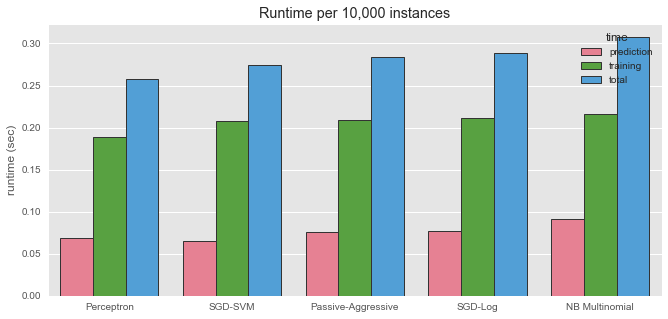

In [194]:
time_res = ts.get_time_res(results)
ts.plot_time(time_res)

In [197]:
train_time = results['NB Multinomial']['train_time']
pd.Series(train_time).sum()


7.1835124492645264

Fig 1. The naive Bayes multinomial classifier took the longest prediction time, but it took much shorter time to train, thus resulted the shortest total time, almost the half of others. The rest of four classifier took almost the same time, ranging near .08 sec in total time. However, I'd say all classifiers can train fairly quickly. The slowest model, SGD logistic took only about 12 seconds to train the whole instances in training set. 

## 2. Accuracy and F-beta score

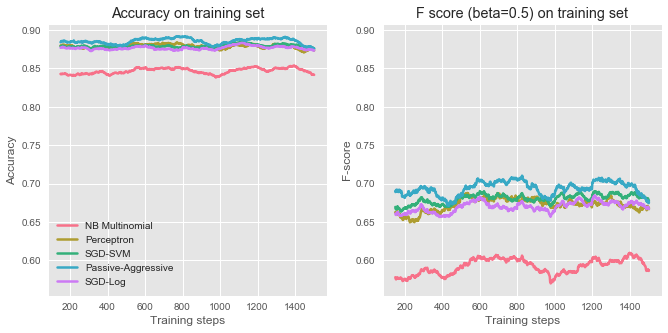

In [198]:
def plot_score(results, window=20):
    my_col = sns.color_palette("husl", 5)
    plt.figure(figsize=(11, 11))
    ax1 = plt.subplot(221)

    for i, clf_name in enumerate(partial_fit_classifiers.keys()):
        plt.plot(pd.Series(results[ clf_name ][ 'acc_train' ]).rolling(window=window).mean(),
                 color=my_col[ i ], linewidth=2.5)
    plt.ylabel("Accuracy")
    plt.xlabel("Training steps")
    plt.legend(loc="best", labels=partial_fit_classifiers.keys())
    plt.title("Accuracy on training set")

    ax2 = plt.subplot(222, sharey=ax1)
    for i, clf_name in enumerate(partial_fit_classifiers.keys()):
        plt.plot(pd.Series(results[ clf_name ][ 'f_train' ]).rolling(window=window).mean(),
                 color=my_col[ i ], linewidth=2.5)
    plt.ylabel("F-score")
    plt.xlabel("Training steps")
    # plt.legend(loc="best", labels=partial_fit_classifiers.keys())
    plt.title("F score (beta=0.5) on training set")
    plt.savefig("assets/compare_score.png")
    plt.show()
    
plot_score(results, window=150)

In [126]:
acc_test = {}
f_test = {}
for clf_names in partial_fit_classifiers.keys():
    acc_test[clf_names] = results[clf_names]['acc_test']
    f_test[clf_names] = results[clf_names]['f_test']
acc_test = pd.DataFrame(acc_test)
f_test = pd.DataFrame(f_test)
f_test_mean = pd.DataFrame(f_test.mean())
f_test_mean.columns = ['f_test_mean']
acc_test_mean = pd.DataFrame(acc_test.mean())
acc_test_mean.columns = ['acc_test_mean']
acc_test_mean.join(f_test_mean)

,acc_test_mean,f_test_mean
NB Multinomial,0.843164,0.598543
Passive-Aggressive,0.826888,0.554192
Perceptron,0.828906,0.543654
SGD-Log,0.868815,0.664476
SGD-SVM,0.867839,0.662742


In [129]:
def get_test_score(results):
    acc_test = {}
    f_test = {}
    for clf_names in partial_fit_classifiers.keys():
        acc_test[clf_names] = results[clf_names]['acc_test']
        f_test[clf_names] = results[clf_names]['f_test']
    acc_test = pd.DataFrame(acc_test)
    f_test = pd.DataFrame(f_test)
    f_test_mean = pd.DataFrame(f_test.mean())
    f_test_mean.columns = ['f_test_mean']
    acc_test_mean = pd.DataFrame(acc_test.mean())
    acc_test_mean.columns = ['acc_test_mean']
    mean_scores = acc_test_mean.join(f_test_mean).sort_values(by='f_test_mean', ascending=False)
    return mean_scores, acc_test, f_test

In [130]:
mean_scores, acc_test, f_test = get_test_score(results)
mean_scores

,acc_test_mean,f_test_mean
SGD-Log,0.868815,0.664476
SGD-SVM,0.867839,0.662742
NB Multinomial,0.843164,0.598543
Passive-Aggressive,0.826888,0.554192
Perceptron,0.828906,0.543654


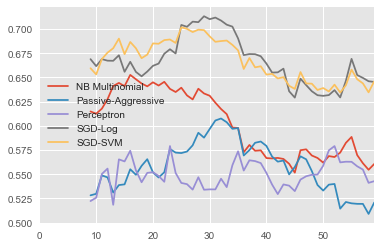

In [131]:
pd.rolling_mean(f_test, 10).plot()

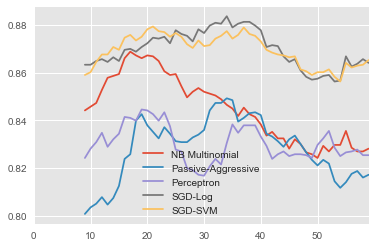

In [132]:
pd.rolling_mean(acc_test, 10).plot()

In [87]:
test_results = get_test_score(results)
test_results

,mean_test_acc,mean_test_f
clf,,
SGD-Log,0.868815,0.664476
SGD-SVM,0.867839,0.662742
NB Multinomial,0.843164,0.598543
Perceptron,0.828906,0.543654
Passive-Aggressive,0.826888,0.554192


As shown in the train evaluation plot, linear SVM and logistic regression with SGD scored higher than the rest. 

# Hyperparameter tuning via grid search

As GridSearchCV in scikit-learn doesn't support algorithms with partial fit, let's manually search the hyperparameter space. 

In [133]:
loss = ['log', 'hinge']
alpha = [.000001, .00001, .0001, .001]
l1_ratio = [0., .1, .2, .3, .4, .5, .6, .7, .8, .9]

In [160]:
def eval_error(clf, val_features, val_labels, n_to_try=100):
    val_fscore = []
    val_accuracy = []
    try:
        for _ in range(n_to_try):
            X_val, y_val = ts.load_random_test_batch(val_features, val_labels, batch_size)
            pred_val = clf.predict(X_val)
            val_fscore.append(fbeta_score(y_val, pred_val, beta=.5))
            val_accuracy.append(accuracy_score(y_val, pred_val))
    
    except StopIteration:
        return None
    
    return np.mean(val_fscore), np.mean(val_accuracy)

In [161]:
def sgd_grid_search(train_batch_names, val_features, val_labels,
                    loss, alpha, l1_ratio, random_state, save_res=True):
    classes = np.array([ 0, 1 ])
    params = list(itertools.product(alpha, l1_ratio))
    params_ = list(itertools.product(loss, params))
    param_dict = [ {'loss': c[ 0 ],
                    'alpha': c[ 1 ][ 0 ],
                    'l1_ratio': c[ 1 ][ 1 ],
                    'val_f_score': 0.} for c in params_ ]

    start = time.time()
    for i, p in enumerate(param_dict):
        clf = SGDClassifier(loss=p[ 'loss' ], alpha=p[ 'alpha' ], l1_ratio=p[ 'l1_ratio' ],
                            penalty='elasticnet', random_state=random_state)
        print('')
        logging.info("{}/{} Evaluating hyperparameters: ".format(i + 1, len(param_dict)))
        logging.info("loss: {}, alpha: {}, l1_ratio: {}".format(p['loss'], p['alpha'], p['l1_ratio']))
        
        for batch_i in range(len(train_batch_names)):
            for X_train, y_train in ts.load_train_batches(train_batch_names, batch_i, batch_size):
                clf.partial_fit(X_train, y_train, classes=classes)

        
        val_fscore, val_accuracy = eval_error(clf, val_features, val_labels)
        p[ 'val_f_score' ] = val_fscore
        logging.info('Validation F-score: {}'.format(val_fscore))

    logging.info("Total time elapsed: {} seconds".format(time.time() - start))

    res = pd.DataFrame(param_dict)
    if save_res:
        pickle_name = 'results/grid_search_res.pickle'
        with open(pickle_name, 'wb') as f:
            pickle.dump(res, f)
        f.close()
        logging.info("grid seach result is saved as: {}".format(pickle_name))

    return res

In [141]:
search_res = sgd_grid_search(train_batch_names, val_features, val_labels, loss, alpha, l1_ratio, random_state)


INFO 1/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.0
INFO Validation F-score: 0.5454334166573277

INFO 2/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.1
INFO Validation F-score: 0.46680586876954294

INFO 3/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.2
INFO Validation F-score: 0.54356460064556

INFO 4/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.3
INFO Validation F-score: 0.5719034532659454

INFO 5/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.4
INFO Validation F-score: 0.435405103560653

INFO 6/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.5
INFO Validation F-score: 0.4556423672185753

INFO 7/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.6
INFO Validation F-score: 0.5286462991656397

INFO 8/80 Evaluating hyperparameters: 
INFO loss: log, alpha: 1e-06, l1_ratio: 0.7
INFO Validation F-scor

INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.3
INFO Validation F-score: 0.6348154135641315

INFO 65/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.4
INFO Validation F-score: 0.6451859860328852

INFO 66/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.5
INFO Validation F-score: 0.6445293387514427

INFO 67/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.6
INFO Validation F-score: 0.6527208915525436

INFO 68/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.7
INFO Validation F-score: 0.6406038253024815

INFO 69/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.8
INFO Validation F-score: 0.6466299085804171

INFO 70/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.0001, l1_ratio: 0.9
INFO Validation F-score: 0.6326114104691613

INFO 71/80 Evaluating hyperparameters: 
INFO loss: hinge, alpha: 0.001, l1_ratio: 0.0
INFO Validation F-score: 0.652

In [142]:
search_res = search_res.sort_values(by='val_f_score', ascending=False)
search_res

,alpha,l1_ratio,loss,val_f_score
73,0.001000,0.3,hinge,0.676440
31,0.001000,0.1,log,0.668312
33,0.001000,0.3,log,0.667827
20,0.000100,0.0,log,0.667381
32,0.001000,0.2,log,0.666575
76,0.001000,0.6,hinge,0.665922
77,0.001000,0.7,hinge,0.664533
72,0.001000,0.2,hinge,0.663938
25,0.000100,0.5,log,0.661633
78,0.001000,0.8,hinge,0.661473


In [143]:
best_param = search_res.iloc[0]
best_param

alpha            0.001
l1_ratio           0.3
loss             hinge
val_f_score    0.67644
Name: 73, dtype: object

In [ ]:
train_batch_names, test_batch_names = ts.get_batch_names(split_val=False)

In [150]:
test_features, test_labels = ts.concat_batches(test_batch_names)

INFO Concatenating 12 batches


0% [############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


In [189]:
best_clf = SGDClassifier(loss=best_param['loss'], 
                         alpha=best_param['alpha'], 
                         l1_ratio=best_param['l1_ratio'], 
                         random_state=random_state,
                         average=True)
classes = np.array([0, 1])

pbar = pyprind.ProgBar(len(train_batch_names))
for batch_i in range(len(train_batch_names)):
    for X_train, y_train in ts.load_train_batches(train_batch_names, batch_i, batch_size):
        best_clf.partial_fit(X_train, y_train, classes=classes) 
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


In [190]:
final_f_score, final_accuracy = eval_error(best_clf, test_features, test_labels)
final_f_score, final_accuracy

(0.67254810675551147, 0.87867187499999999)

Let's save the fine-tuned model

In [191]:
with open('results/best_model.pickle', 'wb') as f:
    pickle.dump(best_clf, f)